In [ ]:
 # standard libraries
import numpy as np
import time
import PIL.Image as Image
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
import datetime
from tqdm.keras import TqdmCallback
from skimage import transform
import requests

# tensorflow libraries
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
train_path = '/content/drive/MyDrive/archive'

# define some variables
batch_size = 32
img_height = 256  # reduced from 600 to mitigate the memory issue
img_width = 256   # reduced from 600 to mitigate the memory issue
seed_train_validation = 1
shuffle_value = True
validation_split = 0.4


# load training images
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=validation_split,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed = seed_train_validation,
  shuffle = shuffle_value )

# load validation images
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=validation_split,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed = seed_train_validation,
    shuffle = shuffle_value )

Found 4652 files belonging to 5 classes.
Using 2792 files for training.
Found 4652 files belonging to 5 classes.
Using 1860 files for validation.


In [ ]:
test_ds_size = int(int(val_ds.__len__()) * 0.5)
test_test_set = val_ds.take(test_ds_size)
test_set = val_ds.skip(test_ds_size)

In [ ]:
class_names = train_ds.class_names

# cleaning the class names
class_names = [x.split('_')[1] if '_' in x else x for x in class_names]

# view class names
print("the target classes are: ", *class_names, sep=", ")


the target classes are: , Caterpillars, Leaflets, DryingofLeaflets, Flaccidity, Yellowing


In [ ]:
# rescaling the images for the model
'''TensorFlow Hub's convention for image models is to expect float inputs in the [0, 1] range'''

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.


'''finish the input pipeline by using buffered prefetching with Dataset.prefetch, so you can yield the data from disk without I/O blocking issues.'''
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Sequential model

In [ ]:
# get the headless model
'''TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.'''

# feature vector model
efficientnet_b7_fv = 'https://kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b7-feature-vector/versions/1'
feature_extractor_model = efficientnet_b7_fv

# feature extraction layer
'''Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. Use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer'''
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(img_width, img_height, 3),
    trainable=False)

# add a classification layer
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2560)              64097680  
                                                                 
 dense (Dense)               (None, 5)                 12805     
                                                                 
Total params: 64,110,485
Trainable params: 12,805
Non-trainable params: 64,097,680
_________________________________________________________________


In [ ]:
# compile the model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Define Epochs
NUM_EPOCHS = 3

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping, TqdmCallback(verbose=0)],verbose=0)

# view model accuracy
model_acc = '{:.2%}'.format(history.history['acc'][-1])
print(f"\n Model Accuracy Reached: {model_acc}")

0epoch [00:00, ?epoch/s]


 Model Accuracy Reached: 92.87%


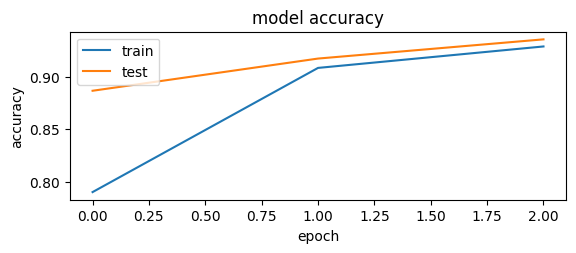

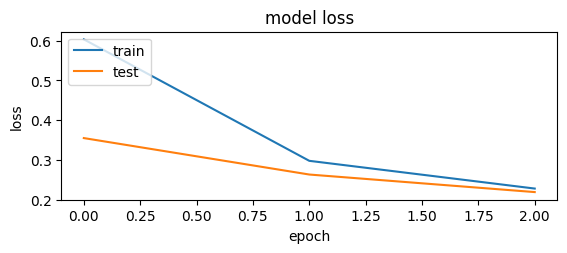

In [ ]:
# summarize history for accuracy
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **VGG16**

In [ ]:
pip install livelossplot

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from livelossplot import PlotLossesKeras
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = vgg16.layers[-1].output
output = Flatten()(output)
vgg16 = Model(vgg16.input, output)
for layer in vgg16.layers:
    layer.trainable = False
vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                            

In [ ]:
model_1 = Sequential()

model_1.add(vgg16)
model_1.add(Dense(128,activation='relu', input_dim=(128,128,3), kernel_regularizer=regularizers.L2(0.05)))
model_1.add(Dense(64,activation='relu', kernel_regularizer=regularizers.L2(0.05)))
model_1.add(Dense(1,activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Recall','Precision','AUC'])

In [ ]:
filepath = "/content/drive/MyDrive/Models/vgg16-model-t5.h5"

callbacks = [ModelCheckpoint(filepath=filepath, monitor="val_accuracy", mode='max', save_best_only=True),
            PlotLossesKeras()]

In [ ]:
h = model_1.fit(train_set,
                epochs=5,
                validation_data=val_set,
                callbacks=callbacks
                )

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


ValueError: ignored

In [ ]:
model_1.evaluate(test_test_set)

29/29 [==============================] - 699s 23s/step - loss: 6229.1611 - accuracy: 0.0970 - recall: 1.0000 - precision: 0.7953 - auc: 0.5000


[6229.1611328125, 0.09698276221752167, 1.0, 0.795258641242981, 0.5]

# **Restnet model**

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
RANDOM_SEED = 42

In [ ]:
path_ = "/content/drive/MyDrive/archive"

In [ ]:
train_batch = 64
test_batch = 64
train_set= image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='categorical',
                                batch_size=train_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.3,
                                subset='training')

val_set =  image_dataset_from_directory(path_,
                                labels='inferred',
                                label_mode='categorical',
                                batch_size=test_batch,
                                seed=RANDOM_SEED,
                                shuffle=True,
                                validation_split=0.3,
                                subset='validation')

Found 4652 files belonging to 5 classes.
Using 3257 files for training.
Found 4652 files belonging to 5 classes.
Using 1395 files for validation.


In [ ]:
test_ds_size = int(34 * 0.5)
test_test_set = val_set.take(test_ds_size)
test_set = val_set.skip(test_ds_size)

In [ ]:
pip install livelossplot

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from livelossplot import PlotLossesKeras
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = restnet.layers[-1].output
output = Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
model_1 = Sequential()

model_1.add(restnet)
model_1.add(Dense(128,activation='relu', input_dim=(256,256,3), kernel_regularizer=regularizers.L2(0.001)))
model_1.add(Dense(64,activation='relu', kernel_regularizer=regularizers.L2(0.001)))
model_1.add(Dense(5,activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','Recall','Precision','AUC'])

In [ ]:
filepath = "/content/drive/MyDrive/Models/resnet-model-t3.h5"

callbacks = [ModelCheckpoint(filepath=filepath, monitor="val_accuracy", mode='max', save_best_only=True),
            PlotLossesKeras()]

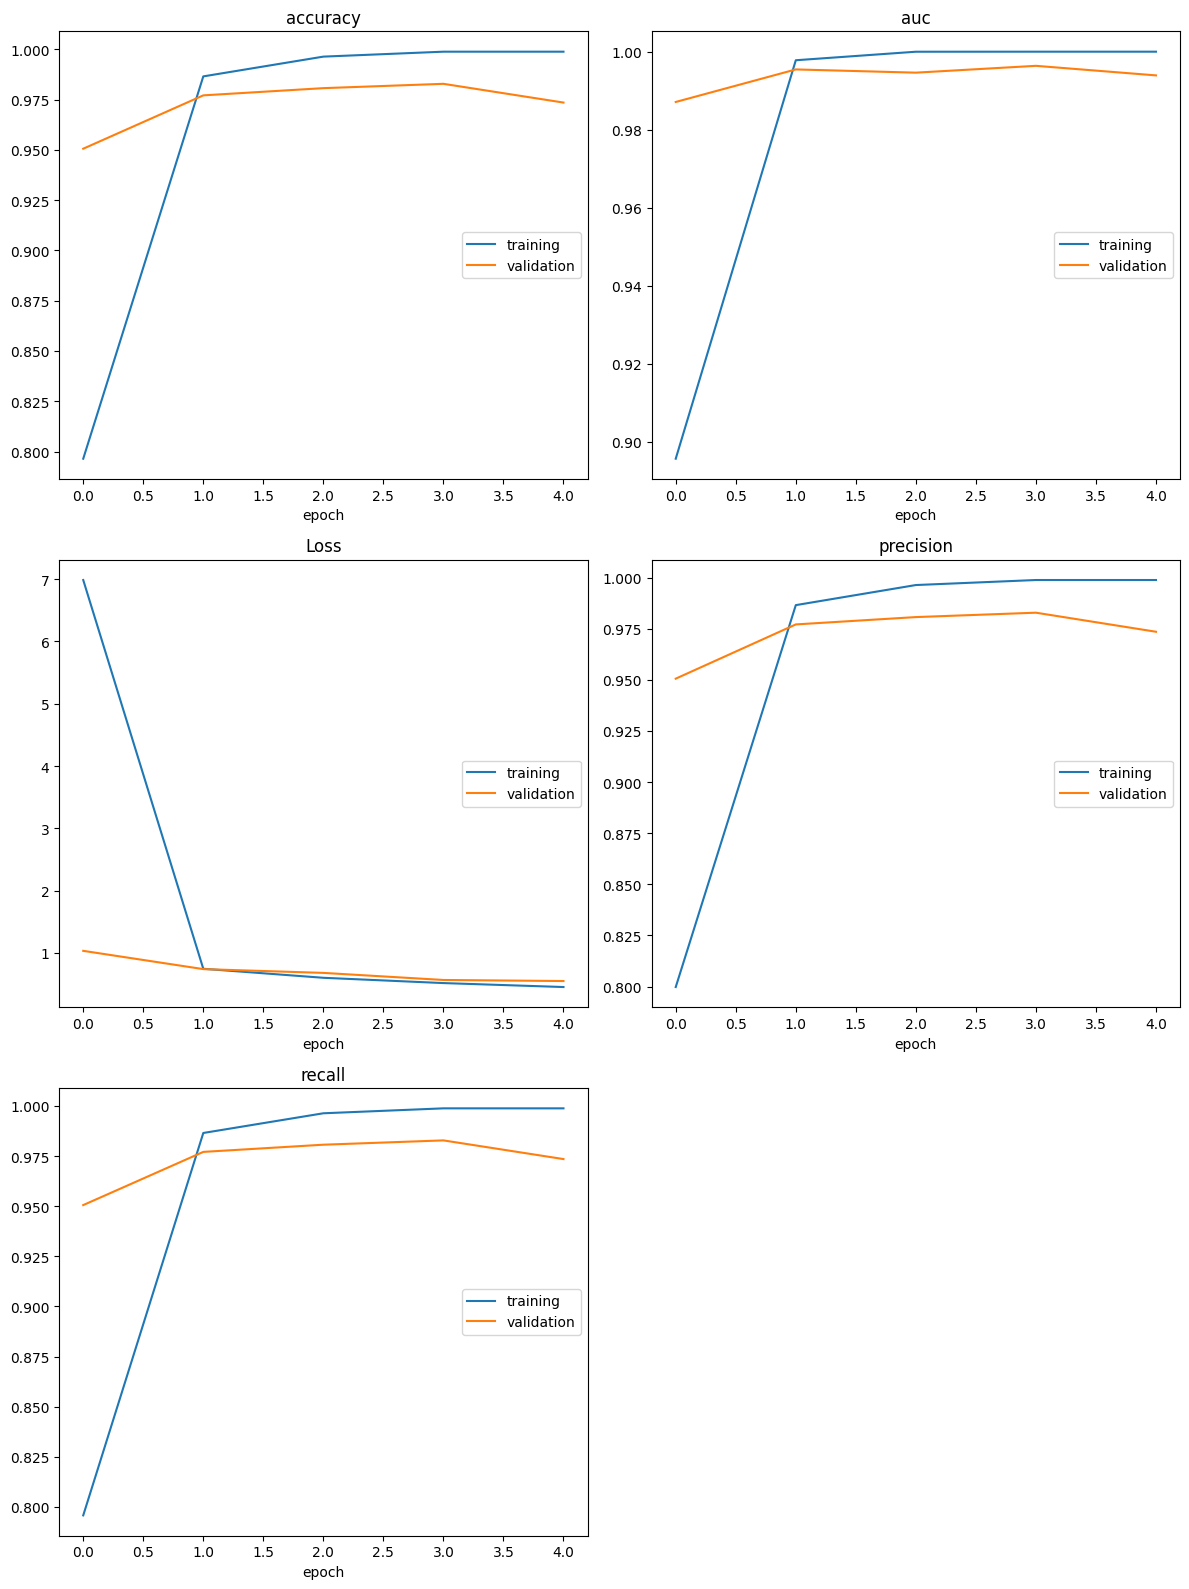

accuracy
	training         	 (min:    0.796, max:    0.999, cur:    0.999)
	validation       	 (min:    0.951, max:    0.983, cur:    0.973)
auc
	training         	 (min:    0.896, max:    1.000, cur:    1.000)
	validation       	 (min:    0.987, max:    0.996, cur:    0.994)
Loss
	training         	 (min:    0.454, max:    6.986, cur:    0.454)
	validation       	 (min:    0.550, max:    1.034, cur:    0.550)
precision
	training         	 (min:    0.800, max:    0.999, cur:    0.999)
	validation       	 (min:    0.951, max:    0.983, cur:    0.973)
recall
	training         	 (min:    0.796, max:    0.999, cur:    0.999)
	validation       	 (min:    0.951, max:    0.983, cur:    0.973)
51/51 [==============================] - 1461s 29s/step - loss: 0.4536 - accuracy: 0.9988 - recall: 0.9988 - precision: 0.9988 - auc: 1.0000 - val_loss: 0.5498 - val_accuracy: 0.9735 - val_recall: 0.9735 - val_precision: 0.9735 - val_auc: 0.9939


In [ ]:
h = model_1.fit(train_set,
                epochs=5,
                validation_data=val_set,
                callbacks=callbacks
                )

In [ ]:
model_1.evaluate(test_test_set)

17/17 [==============================] - 310s 18s/step - loss: 0.5150 - accuracy: 0.9761 - recall: 0.9761 - precision: 0.9761 - auc: 0.9957


[0.5149767994880676,
 0.9761029481887817,
 0.9761029481887817,
 0.9761029481887817,
 0.9957416653633118]